In [1]:
using Pkg

Pkg.activate("..") 
Pkg.instantiate()
using JPEC, Plots
using Revise
gr() 

  Activating project at `c:\Users\thlmi\git\JPEC`
Precompiling project...
  14945.3 ms  ✓ JPEC
  1 dependency successfully precompiled in 72 seconds. 478 already precompiled.


Plots.GRBackend()

### Reading Eq

In [2]:
# 1. Define the input parameters for the equilibrium solver.
#    - eq_filename: The name of the g-file we just created.
#    - eq_type: "efit" for a standard g-file.
#    - jac_type: "boozer" or "hamada" for the output coordinates.
#    - mpsi, mtheta: Resolution of the output grid.
    equil_control = JPEC.Equilibrium.EquilibriumControl(;
    eq_filename="beta_1.00",        # eq_filename
    eq_type="efit",          # eq_type
    jac_type="hamada",        # jac_type
    grid_type="ldp",
    #mpsi = 128,
    #mtheta = 127,
    psilow=0.01,             # psilow
    psihigh=0.990)             # psihigh
equil_config = JPEC.Equilibrium.EquilibriumConfig(equil_control,JPEC.Equilibrium.EquilibriumOutput())
# 2. Run the main equilibrium setup function.
#    This will read the file, solve the direct problem, and return the final object.
println("Starting equilibrium reconstruction...")
plasma_eq = JPEC.Equilibrium.setup_equilibrium(equil_config)
#plasma_eq = JPEC.Equilibrium.setup_equilibrium("./DIIID_example/equil.toml")
println("Equilibrium reconstruction complete.")

┌ Info: Forcing hamada coordinate jacobian exponents: power_*
└ @ JPEC.Equilibrium C:\Users\thlmi\git\JPEC\src\Equilibrium\EquilibriumTypes.jl:48


Starting equilibrium reconstruction...
Equilibrium file: beta_1.00
--> Processing EFIT g-file: beta_1.00
--> Parsed from header: nw=129, nh=128
--> All main data blocks parsed successfully.
--> Creating 1D profile splines...
--> 1D Spline fitting complete.
--> Creating 2D psi spline...
--> 2D Spline fitting complete.
--- Starting Direct Equilibrium Processing ---
Finding magnetic axis...
  Iter  1: R = 3.115238, Z = 0.000008, |ΔR|=1.15e-01, |ΔZ|=1.11e-05
  Iter  2: R = 3.117635, Z = -0.000003, |ΔR|=2.40e-03, |ΔZ|=1.10e-05
  Iter  3: R = 3.117636, Z = -0.000003, |ΔR|=1.07e-06, |ΔZ|=1.04e-09
  Iter  4: R = 3.117636, Z = -0.000003, |ΔR|=2.12e-13, |ΔZ|=5.62e-16
Magnetic axis found at R=3.1176357129137466, Z=-2.9184696943092166e-6.
Finding inboard separatrix crossing...
  Restart attempt 1/6 with initial R = 2.675802
inboard separatrix found at R=1.5000175239830411.
Finding outboard separatrix crossing...
  Restart attempt 1/6 with initial R = 3.500684
outboard separatrix found at R=4.49999

In [49]:
# block2 (수정된 버전)
using Revise
include("../src/DCON/fourfit.jl")

using .Fourfit
# block4

# 1. Calculate the metric tensor from the equilibrium data.
# This is the first major step in a DCON-like stability analysis.

mband = 8 
metric_data = Fourfit.make_metric(plasma_eq; mband=mband,fft_flag=true)



# 2. Construct the MHD stability matrices (F, G, K) from the calculated metric tensors.
# 3. The function finally returns the spline-fitted matrix data along with a diagnostic object for debugging.
println("\nStarting MHD matrix construction...")
nn = 1      #(Toroidal mode number)
mlow = -4  # Lower bound for polloidal mode number
mhigh = 4  # Upper limit for polloidal mode number


matrix_data = Fourfit.make_matrix(
    plasma_eq,
    metric_data;
    nn=nn,
    mlow=mlow,
    mhigh=mhigh,
    sas_flag=false,
    verbose=true
)

println("The MHD matrix configuration is complete.")



🔧 Starting metric tensor calculation...
   Equilibrium grid: 129 (ψ) × 257 (θ)
   Fourier fit modes (mband): 8
📊 Computing metric tensor components...
✅ Grid computation complete.


🔧 Fitting Fourier-spline representation...
 !!
 @@
 ##
 11
 22
✅ Fourier-spline fitting successful.

Starting MHD matrix construction...
🔧 Starting MHD matrix calculation...
   Toroidal mode n=1, Poloidal modes m=-4:4 (9 modes)
   Matrix bandwidth: 8
📊 Computing coefficient matrices on the ψ grid...
✅ Grid computation complete.
🔧 Spline fitting complete.
The MHD matrix configuration is complete.


### CAlc. Metric

In [5]:
# ────────────────────────────────────────────────────────────────
const _COLS = Dict(
    :A => (4, 5),
    :B => (6, 7),
    :C => (8, 9),
    :D => (10, 11),
    :E => (12, 13),
    :H => (14, 15),
)
# ────────────────────────────────────────────────────────────────
mutable struct ImatsReader
    path      :: String
    psi       :: Vector{Float64}
    m_values  :: Vector{Int}
    npsi      :: Int
    mpert     :: Int
    A         :: Array{ComplexF64,3}
    B         :: Array{ComplexF64,3}
    C         :: Array{ComplexF64,3}
    D         :: Array{ComplexF64,3}
    E         :: Array{ComplexF64,3}
    H         :: Array{ComplexF64,3}
end
function ImatsReader(path::AbstractString)
    isfile(path) || throw(ArgumentError("File not found: $path"))

    temp_storage = []
    # 1) Open the Excel file and temporarily read in all rows of data
    XLSX.openxlsx(path) do xf
        sheet = xf[1]
        
        for row in XLSX.eachtablerow(sheet)
        
            ψ = row[1]
            isa(ψ, Number) || continue
        
            mi = Int(row[2])
            mj = Int(row[3])
        
        
            row_data = [row[c] for c in 1:15]
            push!(temp_storage, (ψ, mi, mj, row_data))
        end
    end 

    isempty(temp_storage) && error("No numeric data rows found in $path")
    # 2) Clean up the ψ/m list
    psi_vals = sort(unique(getindex.(temp_storage, 1)))
    m_vals_all = vcat(getindex.(temp_storage, 2), getindex.(temp_storage, 3))
    m_vals   = sort(unique(m_vals_all))
    nψ       = length(psi_vals)
    mpert    = length(m_vals)
    
    
    ψidx = Dict(v => i for (i, v) in enumerate(psi_vals))
    midx = Dict(v => i for (i, v) in enumerate(m_vals))
    # 3) Initialize an empty array to store the final matrix
    shp = (nψ, mpert, mpert)
    mats = Dict(name => zeros(ComplexF64, shp) for name in keys(_COLS))
    # 4) Populate array with temporarily stored data
    for (ψ, mi, mj, row_cells) in temp_storage
        k = ψidx[ψ]
        i = midx[mi]
        j = midx[mj]
        for (name, (recol, imcol)) in _COLS
            
            real_val = row_cells[recol]
            imag_val = row_cells[imcol]
            
            re = isa(real_val, Number) ? Float64(real_val) : 0.0
            im = isa(imag_val, Number) ? Float64(imag_val) : 0.0
            mats[name][k, i, j] = ComplexF64(re, im)
        end
    end
    
    return ImatsReader(String(path), psi_vals, m_vals, nψ, mpert,
               mats[:A], mats[:B], mats[:C], mats[:D], mats[:E], mats[:H])
end
# ────────────────────────────────────────────────────────────────

function _ψindex(r::ImatsReader; ψ_index::Union{Nothing,Int}=nothing,
                                   ψ_value::Union{Nothing,Real}=nothing)
    ψ_index !== nothing && return ψ_index
    ψ_value !== nothing || error("You must specify either ψ_index or ψ_value.")
    return argmin(abs.(r.psi .- ψ_value))
end
# ────────────────────────────────────────────────────────────────
function get_matrix(r::ImatsReader, name::Symbol;
                    ψ_index::Union{Nothing,Int}=nothing,
                    ψ_value::Union{Nothing,Real}=nothing)
    name = Symbol(uppercase(String(name)))
    hasproperty(r, name) || error("unknown matrix $name")
    k = _ψindex(r; ψ_index, ψ_value)
    return getfield(r, name)[k, :, :]
end
function get_matrices(r::ImatsReader; ψ_index::Union{Nothing,Int}=nothing,
                                         ψ_value::Union{Nothing,Real}=nothing)
    k = _ψindex(r; ψ_index, ψ_value)
    return Dict(name => getfield(r, name)[k, :, :] for name in (:A,:B,:C,:D,:E,:H))
end
# ────────────────────────────────────────────────────────────────
Base.show(io::IO, r::ImatsReader) =
    print(io, "ImatsReader(nψ=$(r.npsi), mpert=$(r.mpert), path=\"$(basename(r.path))\")")

In [6]:
using Plots

"""
    plot_ab_heatmaps(A, B; yflip_matrix=true)

A, B : m×m Complex 행렬
0 → white, + → red, − → blue 로 표시하는 2×2 히트맵을 그립니다.
"""
function plot_ab_heatmaps(A::AbstractMatrix{<:Complex}, B::AbstractMatrix{<:Complex};
                          yflip_matrix::Bool = true)

    size(A) == size(B) || error("A and B must have the same size.")
    m, n = size(A)
    Ar, Br = real.(A), real.(B)
    Ai, Bi = imag.(A), imag.(B)

    # 안전한 비율 (분모 0 → NaN)
    re_ratio = Ar ./ Br .- 1
    re_ratio[Br .== 0] .= NaN
    im_ratio = Ai ./ Bi .- 1
    im_ratio[Bi .== 0] .= NaN

    # 차이
    re_diff = Ar .- Br
    im_diff = Ai .- Bi

    xs, ys = 1:n, 1:m
    divmap = cgrad([:blue, :white, :red])  # 음수-0-양수

    # 각 플롯마다 ±max|Z|로 대칭 clims 지정 → 0이 정확히 흰색
    function heatmap_signed(Z; ttl="")
        finite = .!(isnan.(Z) .| isinf.(Z))
        s = any(finite) ? maximum(abs.(Z[finite])) : 1.0
        heatmap(xs, ys, Z;
                xticks = xs, yticks = ys,
                xlabel = "j (column)", ylabel = "i (row)",
                aspect_ratio = :equal, yflip = yflip_matrix,
                color = divmap, clims = (-s, s),
                title = ttl, colorbar = true)
    end

    p1 = heatmap_signed(re_ratio; ttl = "Re(A)/Re(B) - 1")
    p2 = heatmap_signed(im_ratio; ttl = "Im(A)/Im(B) - 1")
    p3 = heatmap_signed(re_diff;  ttl = "Re(A - B)")
    p4 = heatmap_signed(im_diff;  ttl = "Im(A - B)")

    plot(p1, p2, p3, p4; layout=(2,2), size=(1200,900))
end


plot_ab_heatmaps

In [7]:
using LinearAlgebra, Statistics, Plots

function plot_slice_metrics(A3::AbstractArray{<:Complex,3},
                            B3::AbstractArray{<:Complex,3};
                            compute_cond::Bool=false,
                            linkx::Bool=true)

    size(A3) == size(B3) || error("A3 and B3 must have the same size.")
    mpsi, M1, M2 = size(A3)
    xs = 1:mpsi
    xt = mpsi ≤ 30 ? xs : :auto

    relF = zeros(mpsi); rel2 = zeros(mpsi); corr = zeros(mpsi)
    relL1mag = zeros(mpsi); phaseRMS = zeros(mpsi); maxAbsDiff = zeros(mpsi)
    meanAbsReRatio = fill(NaN, mpsi); meanAbsImRatio = fill(NaN, mpsi)
    condA = compute_cond ? zeros(mpsi) : Float64[]
    condB = compute_cond ? zeros(mpsi) : Float64[]

    finite_mean(x) = (f = .!(isnan.(x) .| isinf.(x)); any(f) ? mean(x[f]) : NaN)

    for k in 1:mpsi
        A = Array(@view A3[k, :, :]); B = Array(@view B3[k, :, :])

        d = A - B

        relF[k] = norm(d) / max(eps(), norm(B))

        fro(x) = sqrt(sum(abs2, x))

        rel2[k] = opnorm(d, 1) / max(eps(), opnorm(B, 1))       

        corr[k] = abs(dot(vec(A), vec(B))) / max(eps(), fro(A)*fro(B))
  
        relL1mag[k] = finite_mean(abs.(d) ./ abs.(B))

        phaseRMS[k] = sqrt(mean((angle.(A) .- angle.(B)).^2))

        maxAbsDiff[k] = maximum(abs.(d))

        Ar, Br = real.(A), real.(B); Ai, Bi = imag.(A), imag.(B)
        re_ratio = Ar ./ Br .- 1; re_ratio[Br .== 0] .= NaN
        im_ratio = Ai ./ Bi .- 1; im_ratio[Bi .== 0] .= NaN
        meanAbsReRatio[k] = finite_mean(abs.(re_ratio))
        meanAbsImRatio[k] = finite_mean(abs.(im_ratio))

        if compute_cond
            condA[k] = cond(A); condB[k] = cond(B)
        end
    end

    plots = Plots.Plot[]  
    push!(plots, plot(xs, relF,  xlabel="mpsi", ylabel="relF",  title="Rel Frobenius ‖A−B‖/‖B‖", xticks=xt))
    push!(plots, plot(xs, rel2,  xlabel="mpsi", ylabel="rel2",  title="Rel Spectral opnorm ratio",   xticks=xt))
    push!(plots, plot(xs, corr,  xlabel="mpsi", ylabel="corr",  title="Complex Cosine Similarity",   xticks=xt, ylim=(0,1.05)))
    push!(plots, plot(xs, relL1mag,   xlabel="mpsi", ylabel="mean |Δ|/|B|", title="Mean Rel Magnitude Error", xticks=xt))
    push!(plots, plot(xs, phaseRMS,   xlabel="mpsi", ylabel="RMS phase",    title="Phase RMS (rad)",          xticks=xt))
    push!(plots, plot(xs, maxAbsDiff, xlabel="mpsi", ylabel="max |Δ|",      title="Max Abs Difference",       xticks=xt))
    push!(plots, plot(xs, meanAbsReRatio, xlabel="mpsi", ylabel="mean |·|", title="Mean |Re(A)/Re(B)−1|",     xticks=xt))
    push!(plots, plot(xs, meanAbsImRatio, xlabel="mpsi", ylabel="mean |·|", title="Mean |Im(A)/Im(B)−1|",     xticks=xt))

    if compute_cond
        push!(plots, plot(xs, condA, xlabel="mpsi", ylabel="cond(A)", title="cond(A)", xticks=xt))
        push!(plots, plot(xs, condB, xlabel="mpsi", ylabel="cond(B)", title="cond(B)", xticks=xt))
    end

    laycols = compute_cond ? 4 : 3
    layrows = ceil(Int, length(plots)/laycols)
    plt = plot(plots...; layout=(layrows, laycols), size=(1400, 900), link = (linkx ? :x : :none))
    display(plt)

    return Dict(
        :relF => relF, :rel2 => rel2, :corr => corr,
        :relL1mag => relL1mag, :phaseRMS => phaseRMS, :maxAbsDiff => maxAbsDiff,
        :meanAbsReRatio => meanAbsReRatio, :meanAbsImRatio => meanAbsImRatio,
        :condA => compute_cond ? condA : Float64[],
        :condB => compute_cond ? condB : Float64[],
    )
end


plot_slice_metrics (generic function with 1 method)

In [8]:
using XLSX
reader = ImatsReader("./imats_again.xlsx")

ImatsReader(nψ=129, mpert=9, path="imats_again.xlsx")

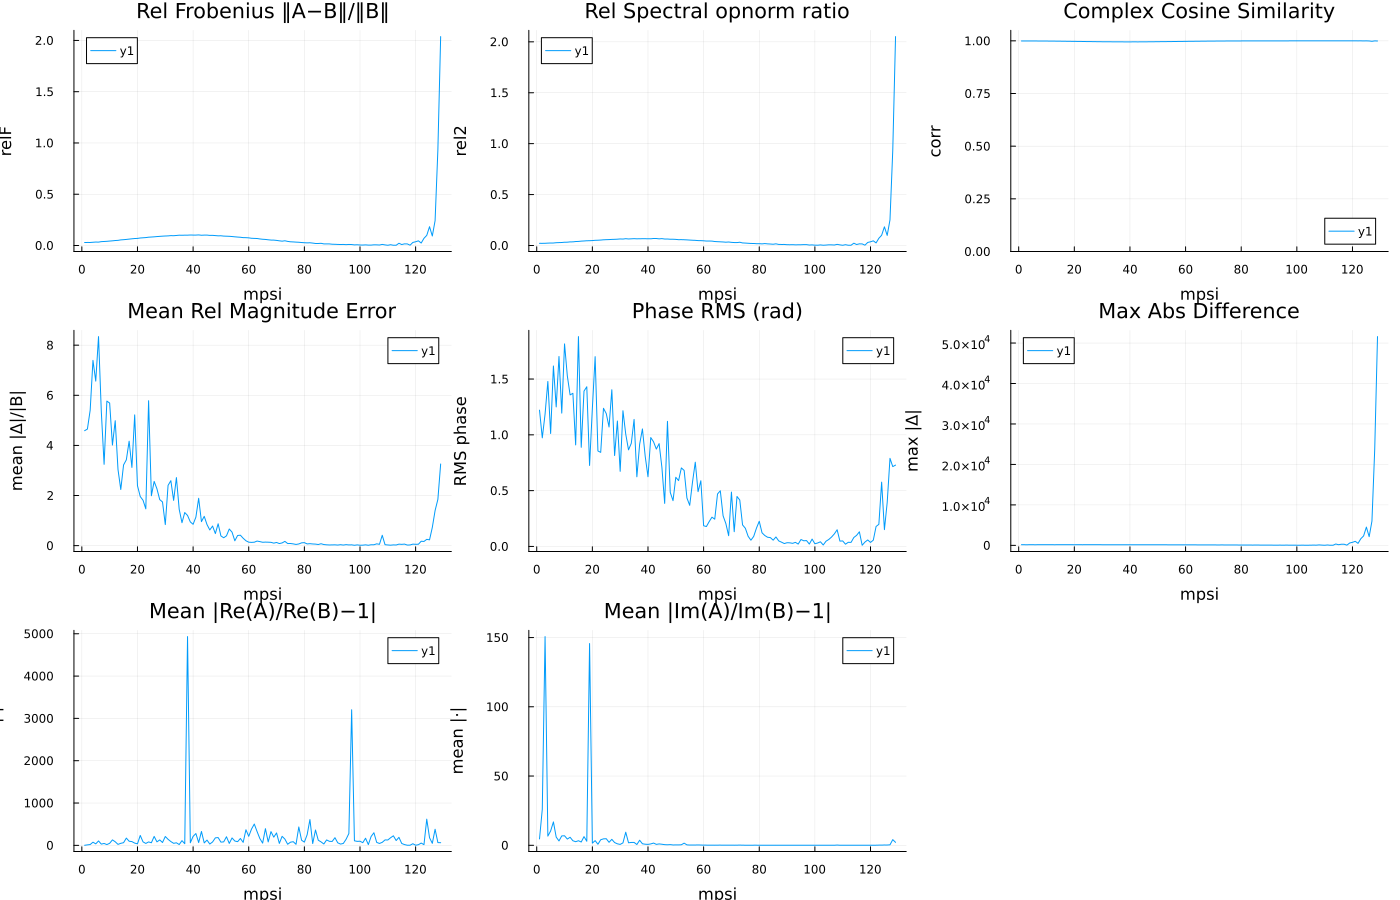

Dict{Symbol, Vector{Float64}} with 10 entries:
  :condA          => []
  :condB          => []
  :meanAbsImRatio => [4.58254, 25.9896, 150.686, 6.62172, 10.3414, 16.8769, 5.9…
  :rel2           => [0.0212087, 0.0211249, 0.0216192, 0.0232371, 0.0243381, 0.…
  :corr           => [0.999572, 0.999566, 0.999566, 0.999504, 0.999437, 0.99946…
  :relL1mag       => [4.58704, 4.65191, 5.40712, 7.39333, 6.56601, 8.3425, 5.34…
  :meanAbsReRatio => [1.83642, 10.9042, 18.9921, 75.1011, 34.9724, 104.218, 29.…
  :relF           => [0.0292807, 0.0294995, 0.0294634, 0.0314964, 0.0336049, 0.…
  :maxAbsDiff     => [153.418, 153.378, 150.232, 154.993, 158.209, 147.484, 159…
  :phaseRMS       => [1.22135, 0.973215, 1.18598, 1.4785, 1.01214, 1.61715, 1.2…

In [50]:
mlow_val = -4
mhigh_val = 4
mpert = mhigh_val - mlow_val + 1


ReaderMatrix = copy(reader.C)
DiagMatrix = matrix_data.cmat_diagnostics


# C, E is slight different (Complex Cosine Similarity)
slice = ReaderMatrix[10,:,:]
mat_slice = DiagMatrix[10,:,:]

# C: transpose하면 cosine similarity는완전 동일한데 imaginary가 다름.
# 


metrics = plot_slice_metrics(ReaderMatrix, DiagMatrix; compute_cond=false)

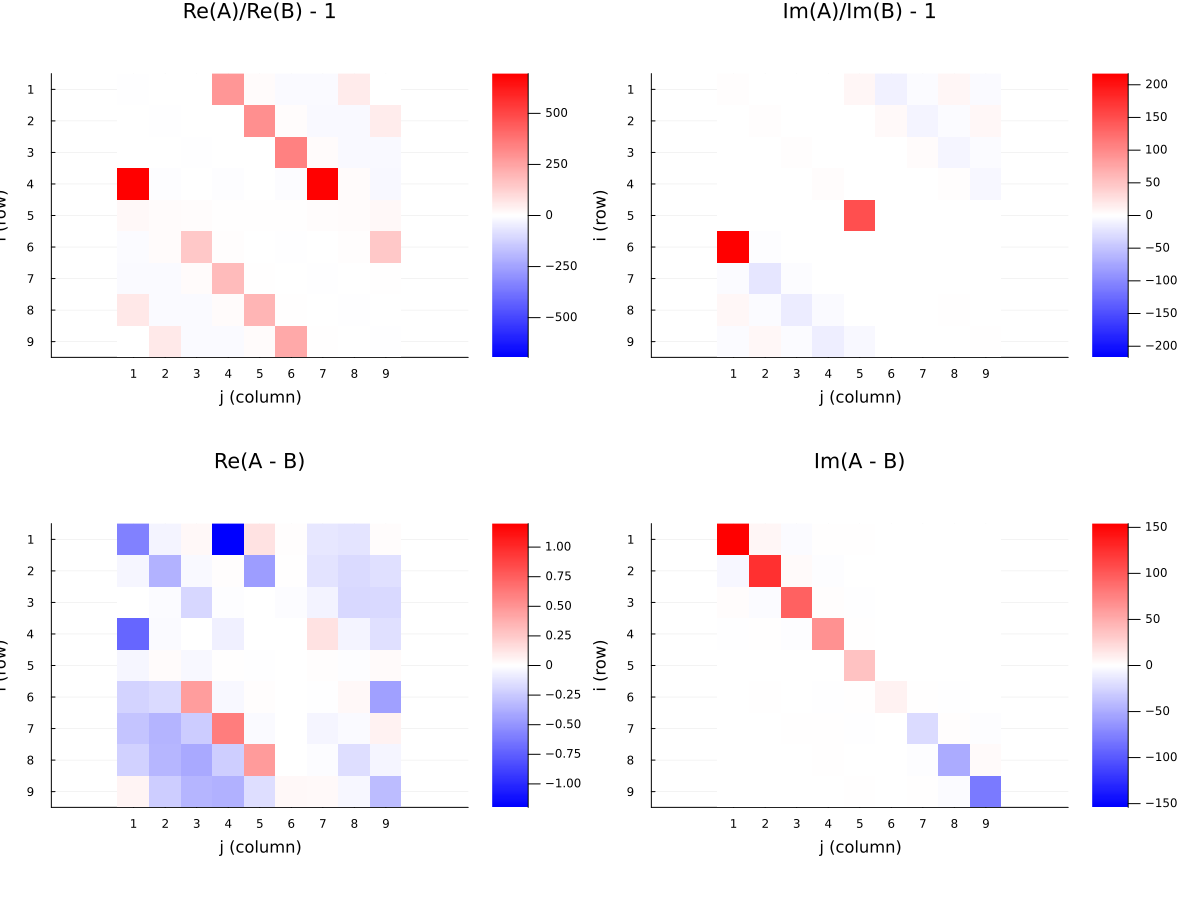

In [51]:
plot_ab_heatmaps( slice, mat_slice)

In [39]:
idx = 2
Iidx = idx
Jidx = idx
println("$(slice[Iidx,Jidx]), $(mat_slice[Iidx,Jidx])")
println("$(real(slice[Iidx,Jidx])/real(mat_slice[Iidx,Jidx])) ,  $(imag(slice[Iidx,Jidx])/imag(mat_slice[Iidx,Jidx]))")
println("$(slice[Iidx,Jidx]-mat_slice[Iidx,Jidx])")
#display(slice)



-0.258093506 + 211.523666im, 0.10500314256688682 + 86.7407653409762im
-2.4579598256842154 ,  2.438572742222238
-0.3630966485668868 + 124.7829006590238im


### Calc. Metric2

In [12]:
display(mat_slice)

9×9 Matrix{ComplexF64}:
    0.177425+115.572im      …    -0.033786-0.0291963im
  -0.0922408-3060.53im         -0.00273785-0.0024453im
   0.0184605-105.914im           0.0112605-0.0308998im
 -0.00103774+5.55801im           0.0081776+0.0177903im
 -0.00236164-0.342045im         0.00137924-0.199283im
   0.0177069+0.000588796im  …  -0.00296462+3.19984im
   0.0222739+0.0740107im         0.0173923-36.9257im
 -0.00352442+0.00969158im       -0.0633002+1778.64im
  -0.0730368+0.0719806im           0.11349-115.078im

In [13]:
include("../src/DCON/fourfit.jl")
import .fourfit_make_metric, .MetricData, .fourfit_make_matrix, .MatrixData, .compute_eigenvalues